In [2]:
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay, auc
import matplotlib.pyplot as plt

In [3]:
data = pd.read_csv("employee_attrition_train.csv")

In [4]:
data.head(3)

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,50.0,No,Travel_Rarely,1126.0,Research & Development,1.0,2,Medical,1,997,...,3,80,1,32,1,2,5,4,1,3
1,36.0,No,Travel_Rarely,216.0,Research & Development,6.0,2,Medical,1,178,...,4,80,2,7,0,3,3,2,0,1
2,21.0,Yes,Travel_Rarely,337.0,Sales,7.0,1,Marketing,1,1780,...,2,80,0,1,3,3,1,0,1,0


In [5]:
data_mod = data.drop(columns=["EmployeeCount", "EmployeeNumber", "StandardHours", "JobRole", "EducationField", "Department"])
data_mod.loc[data_mod.Attrition == "No", "Attrition"] = 0
data_mod.loc[data_mod.Attrition == "Yes", "Attrition"] = 1

In [6]:
y = data_mod.Attrition
x = data_mod.drop(columns=["Attrition"])
cat_cols = x.select_dtypes("object").columns
num_cols = x.select_dtypes(["int64", "float64"]).columns

In [7]:
y = y.astype("int64")

In [8]:
cat_transformed = pd.get_dummies(x[cat_cols])
num_transformed = pd.DataFrame(StandardScaler().fit_transform(x[num_cols]), columns=num_cols)

In [9]:
x_transformed = pd.concat([cat_transformed, num_transformed], axis=1)

In [10]:
x_transformed = x_transformed.fillna(0)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(x_transformed, y)

In [12]:
y_train.value_counts()

0    647
1    124
Name: Attrition, dtype: int64

0.8107729648991785
Best Parameters RandomForestClassifier(max_depth=4, min_samples_split=4)
Roc-Auc Score 0.8107729648991785
0.7428584764749813
Best Parameters KNeighborsClassifier(n_neighbors=19)
Roc-Auc Score 0.7428584764749813
0.7298823749066466
Best Parameters DecisionTreeClassifier(max_depth=3)
Roc-Auc Score 0.7298823749066466
0.8398058252427184
Best Parameters LogisticRegression(solver='liblinear')
Roc-Auc Score 0.8398058252427184


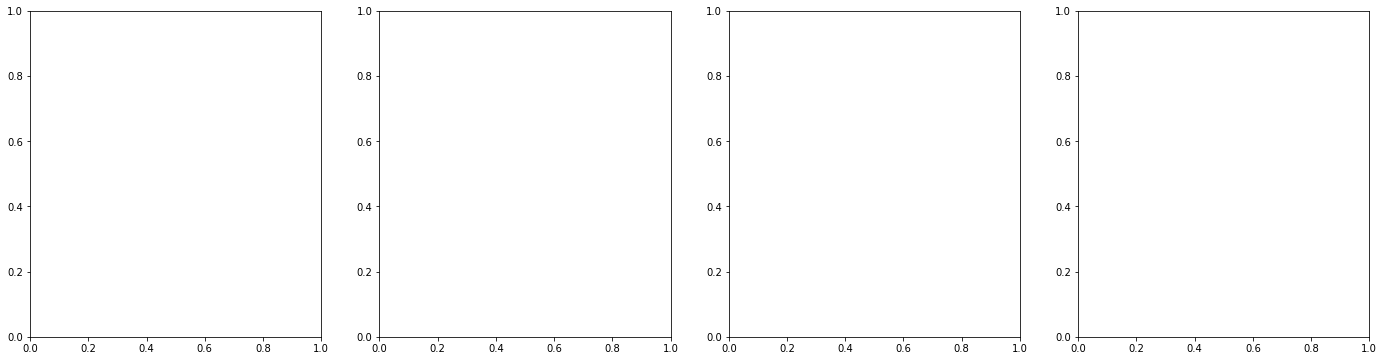

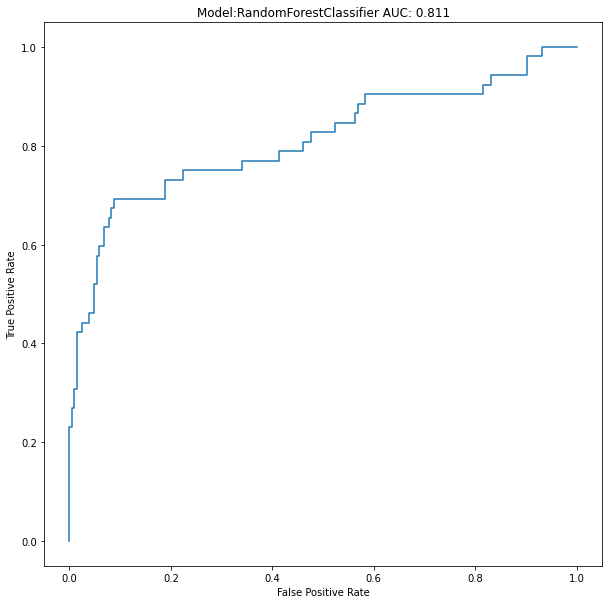

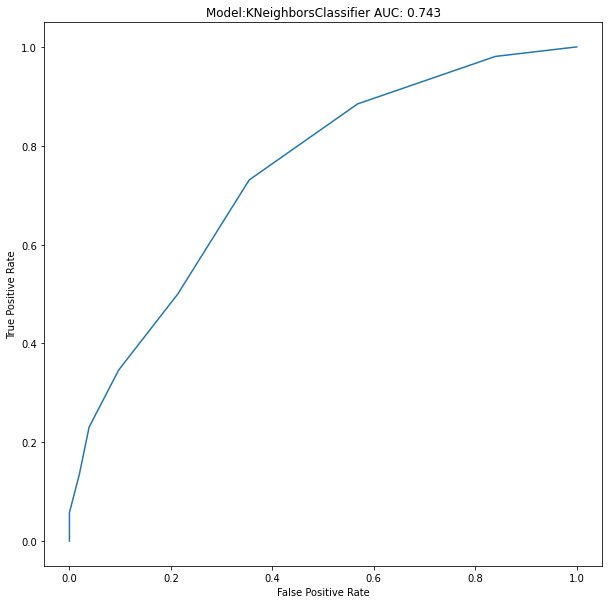

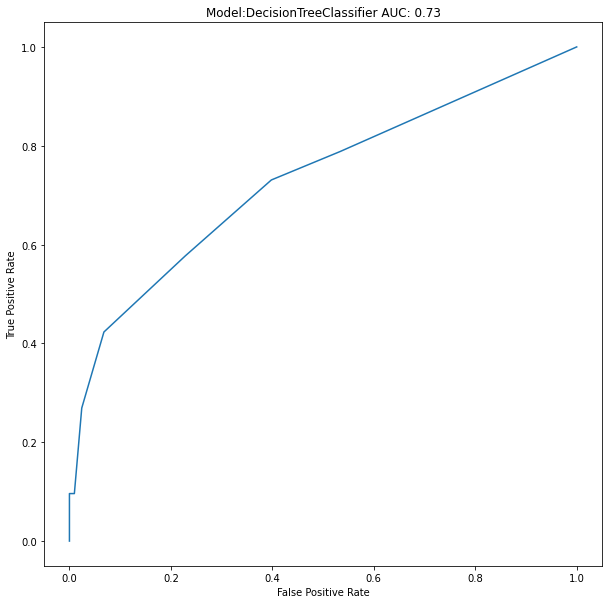

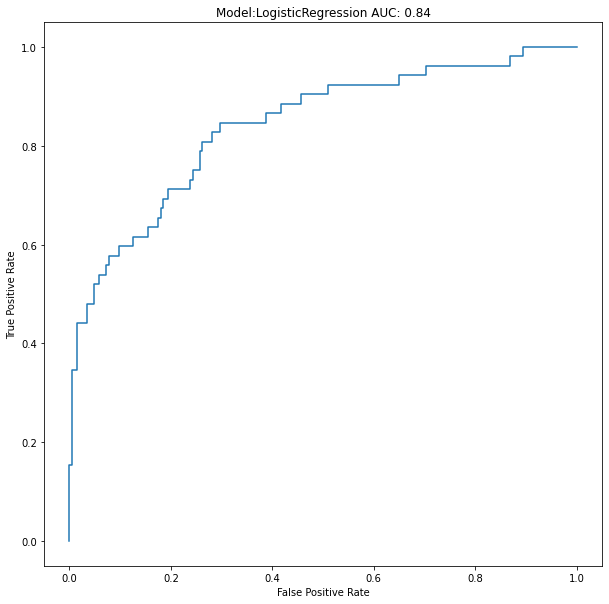

In [16]:
log_reg = LogisticRegression(solver="liblinear")
rf = RandomForestClassifier()
k_neighbors = KNeighborsClassifier()
decision_tree = DecisionTreeClassifier()
perceptron = Perceptron()

log_reg_params = {"penalty": ["l1", "l2"]}

decision_tree_params = {"max_depth": [2,3,4]}

rf_params = {"n_estimators":[50, 100, 150], 
             "max_depth": range(2,6),
             "min_samples_split": [2,4,6]}

k_neighbors_params = {"n_neighbors": range(3,30),
                      "weights": ["uniform","distance"]}

perceptron_params = {"penalty": ["l1", "l2"]}

def evaluate(estimator, params):
    cv = GridSearchCV(estimator=estimator,
                      cv=3,
                      param_grid=params,
                      scoring="roc_auc").fit(X_train, y_train)
    
    print(cv.score(X_test, y_test))
    
    # give back the probability for label 1 
    prob_one = [i[1] for i in cv.predict_proba(X_test)]
    
    # get the false postitive and true positive rate
    fpr, tpr, thresholds = roc_curve(y_test, prob_one)
    
    name = str(estimator).split("(")[0]
    
    # display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
    #                                   estimator_name=name)
    # display.plot()
    
    
    return cv, fpr, tpr
    
eval_params = [(rf, rf_params), 
               (k_neighbors, k_neighbors_params),
               (decision_tree, decision_tree_params),
               (log_reg, log_reg_params)]  

fig, axs = plt.subplots(1, 4, figsize=(24,6))
fig.patch.set_facecolor('white')


for i, (est, params) in enumerate(eval_params):
    cv, fpr, tpr = evaluate(est, params)

    fig, ax = plt.subplots(figsize=(10,10))

    roc_auc = auc(fpr, tpr)    
    
    # axs[i].plot(fpr, tpr)
    # axs[i].set_xlabel("False Positive Rate")
    # axs[i].set_ylabel("True Positive Rate")
    # axs[i].title.set_text("Model:" + str(est).split("(")[0] + " AUC: " + str(round(roc_auc, 3)))
    
    
    ax.plot(fpr, tpr)
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.title.set_text("Model:" + str(est).split("(")[0] + " AUC: " + str(round(roc_auc, 3)))
    
    
    
    print("Best Parameters", cv.best_estimator_)
    print("Roc-Auc Score", roc_auc)